Conversion reaction
===================

In [1]:
import importlib
import os
import sys
import numpy as np
import amici
import amici.plotting
import pypesto

# sbml file we want to import
sbml_file = 'conversion_reaction/model_conversion_reaction.xml'
# name of the model that will also be the name of the python module
model_name = 'model_conversion_reaction'
# directory to which the generated model code is written
model_output_dir = 'tmp/' + model_name

## Compile AMICI model

In [2]:
# import sbml model, compile and generate amici module
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         verbose=False)

## Load AMICI model

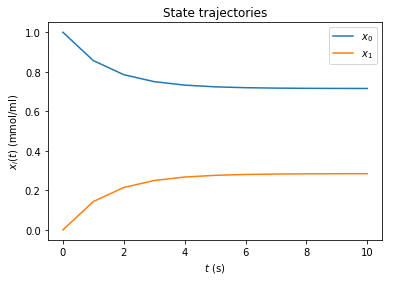

In [3]:
# load amici module (the usual starting point later for the analysis)
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()
model.requireSensitivitiesForAllParameters()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 11)))
model.setParameterScale(amici.ParameterScaling_log10)
model.setParameters(amici.DoubleVector([-0.3,-0.7]))
solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod_forward)
solver.setSensitivityOrder(amici.SensitivityOrder_first)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)
edata = amici.ExpData(rdata, 0.2, 0.0)

## Optimize

In [4]:
# create objective function from amici model
# pesto.AmiciObjective is derived from pesto.Objective, 
# the general pesto objective function class
objective = pypesto.AmiciObjective(model, solver, [edata], 1)

# create optimizer object which contains all information for doing the optimization
optimizer = pypesto.ScipyOptimizer(method='ls_trf')

#optimizer.solver = 'bfgs|meigo'
# if select meigo -> also set default values in solver_options
#optimizer.options = {'maxiter': 1000, 'disp': True} # = pesto.default_options_meigo()
#optimizer.startpoints = []
#optimizer.startpoint_method = 'lhs|uniform|something|function'
#optimizer.n_starts = 100

# see PestoOptions.m for more required options here
# returns OptimizationResult, see parameters.MS for what to return
# list of final optim results foreach multistart, times, hess, grad, 
# flags, meta information (which optimizer -> optimizer.get_repr())

# create problem object containing all information on the problem to be solved
problem = pypesto.Problem(objective=objective, 
                          lb=[-2,-2], ub=[2,2])

# maybe lb, ub = inf
# other constraints: kwargs, class pesto.Constraints
# constraints on pams, states, esp. pesto.AmiciConstraints (e.g. pam1 + pam2<= const)
# if optimizer cannot handle -> error
# maybe also scaling / transformation of parameters encoded here

# do the optimization
result = pypesto.minimize(problem=problem, 
                          optimizer=optimizer, 
                          n_starts=10)
# optimize is a function since it does not need an internal memory,
# just takes input and returns output in the form of a Result object
# 'result' parameter: e.g. some results from somewhere -> pick best start points

## Visualize

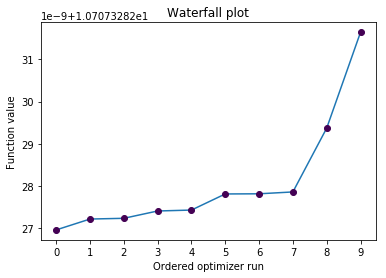

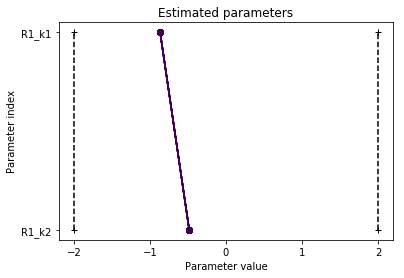

In [5]:
# waterfall, parameter space, scatter plots, fits to data
# different functions for different plotting types
import pypesto.visualize

pypesto.visualize.waterfall(result)
pypesto.visualize.parameters(result)

## Data storage

In [6]:
# result = pypesto.storage.load('db_file.db')

## Profiles

In [7]:
# there are three main parts: optimize, profile, sample. the overall structure of profiles and sampling
# will be similar to optimizer like above.
# we intend to only have just one result object which can be reused everywhere, but the problem of how to 
# not have one huge class but
# maybe simplified views on it for optimization, profiles and sampling is still to be solved

# profiler = pypesto.Profiler()

# result = pypesto.profile(problem, profiler, result=None)
# possibly pass result object from optimization to get good parameter guesses

## Sampling

In [8]:
# sampler = pypesto.Sampler()

# result = pypesto.sample(problem, sampler, result=None)

In [9]:
# open: how to parallelize. the idea is to use methods similar to those in pyabc for working on clusters.
# one way would be to specify an additional 'engine' object passed to optimize(), profile(), sample(),
# which in the default setting just does a for loop, but can also be customized.